In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/strip-ai-new-data/output/train/tiles2/2c8b18_0_0_0.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/611a50_0_1_2.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/98123e_0_0_1.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/2b7304_2_0_1.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/992abf_0_1_0.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/599e16_0_1_0.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/ea2aad_0_0_0.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/73c9a4_0_4_2.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/32e44f_0_1_1.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/992abf_0_2_1.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/6baf51_0_0_4.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/5415fe_0_2_0.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/ba8305_0_1_1.tif
/kaggle/input/strip-ai-new-data/output/train/tiles2/0ee750_0_1_2.tif
/kaggle/input/strip-ai-new-data/ou

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import random

import torch
import torch.nn as nn
from torchvision import models,transforms
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset,random_split
from PIL import Image
from pathlib import Path
from glob import glob

from collections import defaultdict
from openslide import OpenSlide

from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage.exposure import is_low_contrast
from collections import defaultdict
from skimage.io import imread
from PIL import Image
from pathlib import Path
from tqdm import tqdm

random.seed(19)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
orig_data_path='../input/mayo-clinic-strip-ai/'

train_path = orig_data_path + 'train/'
other_path = orig_data_path + 'other/'
train_csv_data = pd.read_csv(orig_data_path + 'train.csv')
other_csv_data = pd.read_csv(orig_data_path + 'other.csv')

In [4]:
path_train_images = '/kaggle/input/strip-ai-new-data/output/train/tiles2'
train_ids = next(os.walk(path_train_images))[2]
img_list = os.listdir('/kaggle/input/strip-ai-new-data/output/train/tiles2')

In [5]:
low_sc_images = []
def load_train_df():
    train_df = defaultdict(list)
    img_indx = 0
    print('Loading train images...')
    for i, proc_image_id in tqdm(enumerate(train_ids), total=len(train_ids)):
        fnames = ['0ba49d_0', '0ba49d_0', '006388_0']  
        if any(f in proc_image_id for f in fnames):
            continue
        if(train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]].empty):
            continue
            
        label = train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]]['label'].item()
        center_id = train_csv_data.loc[train_csv_data['image_id'] == proc_image_id[:-8]]['center_id'].item()
        path_tiles = path_train_images + proc_image_id
        train_df['image_id'].append(proc_image_id)
        train_df['label'].append(label)
        img_indx += 1
                
    return pd.DataFrame(train_df)

In [6]:
train_df = load_train_df()

Loading train images...


100%|██████████| 4323/4323 [00:06<00:00, 674.26it/s]


In [38]:
def remove_images_by_partial_ids(df, partial_ids_to_remove):
    df_filtered = df[~df['image_id'].str.contains('|'.join(partial_ids_to_remove))]
    df_removed = df[df['image_id'].str.contains('|'.join(partial_ids_to_remove))]
    df_filtered.reset_index(drop=True, inplace=True)
    assert not any(df_filtered['image_id'].str.contains('|'.join(partial_ids_to_remove))), "Verification failed."

    
    return df_filtered, df_removed

In [39]:
ids_to_remove = ['bd0cea_0', '658beb_0', '32e44f_0','8e0244_0','d862da_0','a9573c_0','c5e687_0',
                'c61b26_0','a4e918_0','029c68_0','75ee44_0','283f35_0','006388_0','652471_0',
                 '355354_0','f4d8f8_0','ffec5c_1','a4c877_0','dae554_0','d8db68_0'
                ]

df_train_splitted, df_test_splitted = remove_images_by_partial_ids(train_df, ids_to_remove)

Original DataFrame:
              image_id label
0     2c8b18_0_0_0.tif    CE
1     611a50_0_1_2.tif   LAA
2     98123e_0_0_1.tif    CE
3     2b7304_2_0_1.tif   LAA
4     992abf_0_1_0.tif    CE
...                ...   ...
4308  c9ab6c_0_0_0.tif   LAA
4309  ffec5c_0_1_4.tif   LAA
4310  79d1c1_1_2_0.tif    CE
4311  9f7649_1_2_3.tif   LAA
4312  abc682_0_5_4.tif   LAA

[4313 rows x 2 columns]

DataFrame after removing rows with specified IDs:
              image_id label
0     2c8b18_0_0_0.tif    CE
1     611a50_0_1_2.tif   LAA
2     98123e_0_0_1.tif    CE
3     2b7304_2_0_1.tif   LAA
4     992abf_0_1_0.tif    CE
...                ...   ...
4207  c9ab6c_0_0_0.tif   LAA
4208  ffec5c_0_1_4.tif   LAA
4209  79d1c1_1_2_0.tif    CE
4210  9f7649_1_2_3.tif   LAA
4211  abc682_0_5_4.tif   LAA

[4212 rows x 2 columns]

DataFrame containing removed rows:
              image_id label
8     32e44f_0_1_1.tif    CE
51    75ee44_0_1_3.tif   LAA
59    dae554_0_1_0.tif   LAA
93    d862da_0_0_0.tif   LAA
14

In [7]:
IMG_SIZE = 224

In [8]:
classes = ['CE','LAA']
class_to_int = {classes[i] : i for i in range(len(classes))}

In [46]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, directory, transform=None):
        self.dataframe = dataframe
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = class_to_int[self.dataframe.iloc[idx, 1]]
        
        
        if self.transform:
            image = self.transform(image)

        return image, label


image_shape = (IMG_SIZE, IMG_SIZE)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(df_train_splitted, '/kaggle/input/strip-ai-new-data/output/train/tiles2', transform=transform)
train_size = int(0.8 * len(df_train_splitted))
val_size = len(df_train_splitted) - train_size
print(train_size)
print(val_size)
train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

3369
843


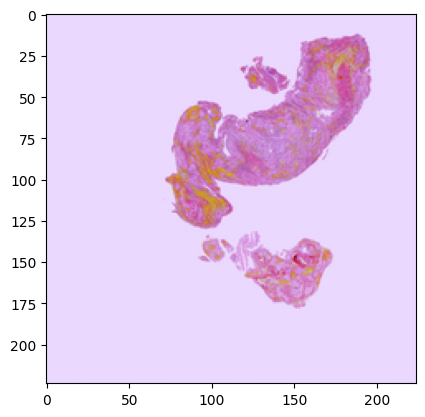

In [47]:
for batch in validation_loader:
    img,label = batch
    img = np.transpose(img[0], (1, 2, 0))
# Plot the image
    plt.imshow(img)
    plt.show()
    break


In [49]:
from sklearn.metrics import accuracy_score
class ResNet50Model(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-7):
        super(ResNet50Model, self).__init__()

        # Load the pretrained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Modify the last fully connected layer to match the number of classes
        out_features = self.resnet50.fc.out_features

        # Additional layers
        self.dense1 = nn.Linear(out_features, 256)  # Adjust the output size
        self.relu = nn.ReLU()

        self.dense2 = nn.Linear(256, num_classes)  # Fix the number of output units
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Learning rate
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.resnet50(x)

        x = self.dense1(x)
        x = self.relu(x)

        x = self.dense2(x)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        _, predictions = torch.max(outputs, 1)
        acc = torch.sum(predictions == y).item() / y.size(0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs,y)
        _, predictions = torch.max(outputs, 1)
        acc = torch.sum(predictions == y).item() / y.size(0)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

In [50]:
from pytorch_lightning.loggers import WandbLogger
import wandb
wandb_logger = WandbLogger(project="blood-clot-resnet",log_model="all")
wandb_logger.experiment.config["batch_size"] = 16
num_classes = 2  
extended_resnet_model = ResNet50Model(num_classes)

checkpoint_loss = ModelCheckpoint(
    dirpath='/kaggle/working/',
    monitor="val_loss",
    filename="resnet50_train_only-loss-{val_loss:.2f}",
    save_top_k=1,
    mode="min"
)

trainer = pl.Trainer(
    logger = wandb_logger,
    accelerator="auto",
    max_epochs=70, 
    callbacks=[checkpoint_loss]
) 

 
trainer.fit(extended_resnet_model,train_loader ,validation_loader)
wandb.finish()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/ exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc_epoch,▁▁▂▃▃▃▄▄▄▄▅▅▅▆▆▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██████
train_acc_step,▁▃▃▄▄▆▃▃▃▄▅█▆▇▆▃▆▄▄▅▄▃▅▆▅▇▆▆▆▅▆▆█▃▅▆▆▃▅▃
train_loss_epoch,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
train_loss_step,█▇▇▆▆▆▆▇█▇▆▃▅▃▃▅▅▆▅▄▅▅▄▃▄▁▄▅▃▄▄▃▁▆▃▁▄█▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇▇▇█▇████████
val_loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch,69
train_acc_epoch,0.80083
train_acc_step,0.75
